Utilizando postiguar:
------------------------------

In [1]:
#Importando os pacotes necessarios para uso:

import numpy as np
import matplotlib.pyplot as plt


#Importando postiguar:
import postiguar as ptg 

# postiguar também pode ser importando em modulo:
#os modulos principais são: models, optimizers, multiparametric_field

from postiguar import models, filters, optimizers, multiparametric_field



Importando dados para o exemplo:
--------------------------------------------------

Importando a "ground truth":

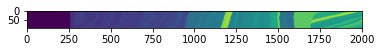

In [2]:
#Os dados podem ser importados normalmente com um vetor/matrix/tensor do numpy:
#aqui trabalharemos com uma matrix 2D:

data_file="./Marmousi2Ztime_dt_001_dx_10_nt_2001_nx_1701.bin" #Matrix contendo a impedância
impedance_shape=(1701,2001) #Forma da matrix de impedância.



ground_truth=np.fromfile(data_file,dtype=np.float32) #Importando os dados.
ground_truth=ground_truth.reshape(impedance_shape) #redimencionando os traços para uma matrix 2D.


#Para este tutorial utilizaremos apenas alguns traços do campo para testarmos as inversões.
xi,xf=500,600 

ground_truth=ground_truth[xi:xf,:].copy()

#Verificando os traços escolhidos.

plt.imshow(ground_truth)

Importando o modelo inicial suavizado:

In [3]:
#Arquivo contendo uma versão suavisada de mesma dimensão do modelo inicial:
data_file="./Initial_Marmousi2Ztime_dt_001_dx_10_nt_2001_nx_1701_suav_40"

smoothed_impedance=np.fromfile(data_file,dtype=np.float32) #Importando os dados.
smoothed_impedance=smoothed_impedance.reshape(impedance_shape) #redimensionando


smoothed_impedance=smoothed_impedance[xi:xf,:].copy() #recortando os mesmos traços do dado ideal.

#Gerando uma visualização dos traços:
plt.imshow(smoothed_impedance)

Criando amplitudes sísmicas sintéticas:
--------------------------------------------------------

Criando wavelet:

In [4]:
#Neste exemplo usaremos uma wavelet causal de ricker.

n_wav=41 #Número de pontos na wavelet
dt=0.001 #Amostragem em segundos.

wavelet_times= np.arange(0,n_wav,1,dtype=np.float64)*dt
wavelet=ptg.utilities.wavelets.ricker(wavelet_times,wavelet_center=dt*(n_wav//2))

#Aqui usamos um pacote de utilidades do postiguar para criar a wavelet, entretando qualquer vetor numpy menor
#que o comprimento do traço sísmico servirá.
plt.plot(wavelet)

In [5]:
#No postiguar por enquanto dispomos apenas de um módulo para realizar inversão de log-impedância m=log (z).
#Ao final da inversão podemos então calcular o valor da impedância acústica por inversão direta de m.
smoothed_impedance=np.log(smoothed_impedance)

#Calculando o tamanho do traço resultante de uma convolução com uma wavelet causal com a impedância:
amplitude_shape=[xf-xi,impedance_shape[-1]+n_wav-2]

Utilizando campos multiparamétricos:

In [6]:
#Aqui aprenderemos a utilizar um dos módulos centrais do postiguar, "multiparametric_fields".
#multiparametric_fields é uma estrutura de dados que coleta campos que serão otimizados simultaneamente.
#Campos adicionados a um container multiparametric_fields são vetorizados e alinhados.
#Todos os modelos disponíveis no postiguar operam primariamente sobre "multiparametric_fields".

#O container oferece várias funções para acesso e manipulação desses campos. Para conferir é só acessar o modo de ajuda
#da sua I.D.E favorita.


input_fields=multiparametric_field() #Primeiramente criamos um container vazio.

#Adicionamos o campo de impedância inicial:
input_fields.add_field(smoothed_impedance,field_name="impedance",short_field_name="m") #Adicionamos um campo
#Os dados serão copiados para o container. Operações com o input_field não vão destruir os dados contidos em soothed_impedance.


#Criando container para os dados ideais:
ideal_fields=multiparametric_field()
ideal_fields.add_field(ground_truth,field_name="impedance(ideal)",
                               short_field_name="Zi")
ideal_fields.add_field(wavelet,field_name="wavelet",
                               short_field_name="w")

#Campos também podem ser criados a partir das dimenções desejadas e populados posteriormente.
#Criando e alocando espaço para amplitudes:
ideal_fields.add_field(field_shape=amplitude_shape,field_name="amplitude",
                          short_field_name="A")

#Criando um campo para os observáveis:
target_fields=multiparametric_field()
target_fields.add_field(field_shape=amplitude_shape,field_name="amplitude",
                           short_field_name="A")


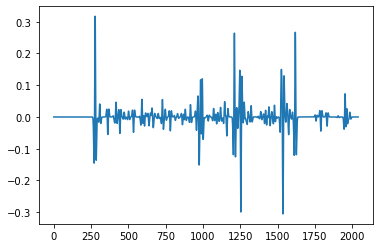

In [7]:
#Para facilitar a prototipagem, criamos alguns filtros para gerar dados sintéticos diretatmente.
#Filtros podem ser utilizados por uma chamada a classe, ou buscados pela função get_filter.


amp_filter=ptg.filters.get_filter("impT2ampT") #Retorna o filtro que convert impedância no tempo para amplitude no tempo.

#Iremos agora passar os campos para os filtros.
#Campos são acessados ou por nome ou por posição. A posição segue a ordem em que eles foram criados.

#Calculando a amplitude ideal:
amp_filter.filter_data(ideal_fields["Zi"],ideal_fields["w"],ideal_fields["A"],
                       causal_wavelet=True,convolution_mode="full")

#Calculando observável sintético (Iremos poluir ele depois):
amp_filter.filter_data(ideal_fields["Zi"],ideal_fields["w"],target_fields["A"],
                       causal_wavelet=True,convolution_mode="full")


#Vamos acessar a amplitude para ver se deu tudo certo:
amplitude=ideal_fields["A"]

plt.plot(amplitude[0,:])

Adicionando ruído na amplitude:

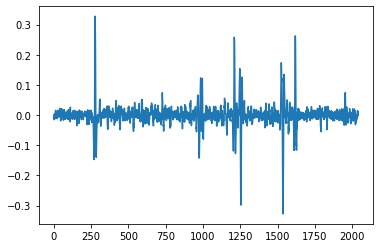

In [8]:
#Vamos poluir a ampplitude idealizada com um ruído de média intensidade.
ptg.filters.add_gaussian_noise.filter_data(target_fields["A"],target_fields["A"],spread=0.01)

#Vamos acessar a amplitude para ver se deu tudo certo:
amplitude=target_fields["A"]

plt.plot(amplitude[0,:])

Criando modelos:
-------------------------

In [9]:
#Modelos são ferramentas que operam sobre campos multiparaétricos. Para usá-los precisamos especificar quais
#campos vamos operar, quais iremos otimizar e qual norma iremos utilizar.
#Especificado isso, os modelos irão compilar internamente uma função objetivo, uma função para calcular o gradiente
#e se o modelo não suave, um operador proximal.

#Podemos acessar os modelos epla função get_model:
inversion_model=models.get_model("convlnimp")
convolution_model=inversion_model(ln_impedance=input_fields["m"],
                                  wavelet=ideal_fields["w"],
                                  amplitude=target_fields["A"],
                                  norm="q-L2",
                                  q=2.9,
                                  causal_wavelet=True,
                                  convolution_mode="full")

#aqui utilizaremos a norma q-L2. essa norma requer que voce passe um valor de q.
#Esse valor também precisa ser específicado para a norma q-L1.
#Caso você utilize a norma k-L2, você deve o valor de k, da mesma forma.

convolution_model.setup() #A função setup deve ser chamada depois de alterar ou iniciar um modelo ou otimizador,

#Nota: Campos sao passados para modelos por associação. Quaisquer mudanças feitas aos campos serão diretamente
#propagadas para os modelos.
#Warning: Por isso, os modelos são violados sempre que um campo for removido de um campo multiparamétrico.
#Ao remover campos recrie todos os modelos. 

Initializing stationary Robinson convolution-model:

epsilon(scaling):      1.0
Residues norm:         q-L2



Criando Otimizadores:
--------------------------------

In [10]:
#Otimizadores recebem uma série de modelos e performam a otimização conjunta destes.


optimizer=optimizers.get_optimizer("scipy")
seismic_optimizer=optimizer(convolution_model,tol=1e-8,
                           method='cg');


seismic_optimizer.setup();

Initializing stationary Robinson convolution-model:

epsilon(scaling):      1.0
Residues norm:         q-L2



In [11]:
#Todos os otimizadores tem a função iterate, que performa um número de iterações.

seismic_optimizer.iterate(50)
#A função retorna True se ocorreu convergência na precisão desejada ou False caso contrario.
#Esse comportamento deve mudar em um futuro próximo.

False

Visualizando o resultado da inversão:

<Figure size 432x288 with 0 Axes>

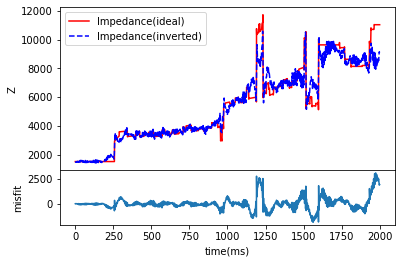

In [12]:
imp_ideal=ideal_fields["Zi"]

imp_inverted=input_fields["m"]
imp_inverted=np.exp(imp_inverted)

plt.figure()
  
    
fig=plt.figure(constrained_layout=False)
gsp=fig.add_gridspec(4,1,hspace=0.)
    
axs1 =fig.add_subplot(gsp[:-1, :])
axs2 =fig.add_subplot(gsp[-1, :])
    
axs1.set_ylabel('Z')
axs1.tick_params(axis="x", labelbottom=False,bottom=False)
    
axs2.set_xlabel('time(ms)')
axs2.set_ylabel('misfit')
    
    
    
    
axs1.plot(imp_ideal[0,:],'r-',label='Impedance(ideal)',linewidth=1.5)
axs1.plot(imp_inverted[0,:],'b--',label='Impedance(inverted)')
axs1.legend()
    
axs2.plot(imp_ideal[0,:]-imp_inverted[0,:])

Vamos fazer uma inversão regularizada agora.

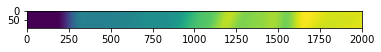

In [13]:
#reiniciando os valores da impedância:

impedance=input_fields["m"]
impedance[...]=smoothed_impedance[...]

plt.imshow(impedance)

Criando regularizador TV:
-------------------------------------

In [14]:
#Regularizadores são implementados como modelos:
tv_regularization=ptg.models.total_variation

#Por enquanto o regularizador TV precisa ser criado para cada dimensão.
#Isso será melhorado no futuro.

tv_reg_x=tv_regularization(input_fields=input_fields["m"],
                           norm="q-L1",
                           q=2.9,
                           epsilon=0.002,
                           order=1,
                           dimensions=0)

tv_reg_x.setup()

#Nota: Epsilon é o chamado parâmetro de regularização. Todos os modelos
#possuem essa variável. Caso ela não seja especificada seu valor é 
#automaticamente marcado como 1.

#Como x é o primeiro índice da matrix, ele é referenciado como dimensão 0.

tv_reg_t=tv_regularization(input_fields=input_fields["m"],
                           norm="q-L1",
                           q=2.9,
                           epsilon=0.002,
                           order=1,
                           dimensions=1)
tv_reg_t.setup()
#o tempo é a segunda e última di mensão, então ela é referenciado como 1.

Initializing Tv-regulalizer:

epsilon(scaling):      0.002
Derivative Order:      (1,)
Derivative Dimensions: [0]
Residues norm:         q-L1

Initializing Tv-regulalizer:

epsilon(scaling):      0.002
Derivative Order:      (1,)
Derivative Dimensions: [1]
Residues norm:         q-L1



Criando otimizador:
----------------------------

In [15]:
#A norma q-L1 não é suave, consequentemente não podemos utilizar métodos continuos para otimizar
#o problema composto. Vamos criar um otimizador do tipo ADMM para este tipo de problema.

seismic_optimizer=ptg.optimizers.ADMM(smooth_model=convolution_model,
                                     nonsmooth_model=[tv_reg_x,tv_reg_t])

seismic_optimizer.setup()

#ADMM é um otimizador bastante complexo que requer o ajuste de uma série de parâmetros para que ele funcione de
#forma eficiente. Detalhes sobre quais parâmtros disponíveis podem ser vistos na documentação do código, por aqui
#iremos utilizar apenas os valores padrões.

Initializing stationary Robinson convolution-model:

epsilon(scaling):      1.0
Residues norm:         q-L2



In [16]:
#performando algumas iterações:

seismic_optimizer.iterate(10)

k=1,Fx=225.23495444820747, dx=9116.477678414825,rk=30.90852002383881,dk=156.46542458757924
k=2,Fx=211.70691505325982, dx=7659.757254553733,rk=7.445240389817002,dk=31.567015767232963
k=3,Fx=210.55478853447477, dx=880.3548789578513,rk=4.506629315446306,dk=12.815244816196268
k=4,Fx=209.91208045189686, dx=366.3772996460694,rk=2.783616362529285,dk=7.890091253787961
k=5,Fx=209.6190234947228, dx=3938.820105618941,rk=2.1001814780880586,dk=5.861964756708451
k=6,Fx=209.02778929433535, dx=297.70971018926815,rk=1.5712955300738247,dk=4.439592539575936
k=7,Fx=208.600456942835, dx=2381.6409540338122,rk=1.3241295900301073,dk=3.713516281848163
k=8,Fx=207.91656775179445, dx=230.80686083902665,rk=1.0743093451553634,dk=3.1098779048590246
k=9,Fx=207.2264800098065, dx=283.05695727993674,rk=0.9066704499517588,dk=2.7052142747769197
k=10,Fx=206.6234391415536, dx=1092.659719488402,rk=0.7936713928234262,dk=2.3401139520130103


False

O otimizador ADMM mostra a evolução da função objetivo a cada iteração.
rk e dk são os resíduos primais e duais da iteração k.

Visualizando os resultados da inversão regularizada:

<Figure size 432x288 with 0 Axes>

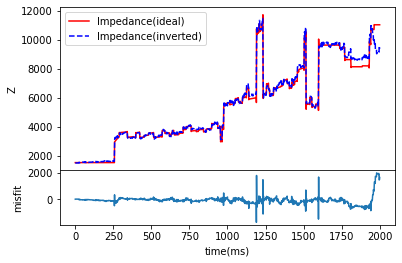

In [17]:
imp_ideal=ideal_fields["Zi"]

imp_inverted=input_fields["m"]
imp_inverted=np.exp(imp_inverted)

plt.figure()
  
    
fig=plt.figure(constrained_layout=False)
gsp=fig.add_gridspec(4,1,hspace=0.)
    
axs1 =fig.add_subplot(gsp[:-1, :])
axs2 =fig.add_subplot(gsp[-1, :])
    
axs1.set_ylabel('Z')
axs1.tick_params(axis="x", labelbottom=False,bottom=False)
    
axs2.set_xlabel('time(ms)')
axs2.set_ylabel('misfit')
    
    
    
    
axs1.plot(imp_ideal[0,:],'r-',label='Impedance(ideal)',linewidth=1.5)
axs1.plot(imp_inverted[0,:],'b--',label='Impedance(inverted)')
axs1.legend()
    
axs2.plot(imp_ideal[0,:]-imp_inverted[0,:])

Já obtivemos uma melhoria e tanto.


#nota: O número de iterações pode ser aumentado para melhorar a qualidade da inversão